In [1]:
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
import scipy.ndimage

# draw the dark hole regions
from skimage.draw import draw

# PSD code
from scipy import signal
import h5py
import copy

# import personal code
import sys
sys.path.insert(0, '/home/jhen/XWCL/code/MagAOX/functions') # change this per computer
import psd_functions as psd
import datafiles as dfx

#import magaoxFunctions as mf

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# generate the PSD
opt_parms = {'ca' : 80, # of the 80% CA given
             'ovs': 4096,
             'surf_units': u.micron,
             'ring_width': 3,
             'diam_ca100': 50*u.mm} # useful for PSD

filename = filename='zygo_data/flat_mirrors/coastline_test/coastline_{0}CA'.format(opt_parms['ca'])
clf = psd.surfPSD(surf_name='coastline_flat')
clf.open_surf(fileloc=filename+'_surf.fits', surf_units=opt_parms['surf_units'])
clf.open_mask(fileloc=filename+'_mask.fits')
clf.calc_psd(oversamp=opt_parms['ovs'])
clf.write_psd_file(filename=filename+'_PSD.fits', psd_data=clf.psd_cal, single_precision=False)
clf.calc_psd_radial(ring_width=opt_parms['ring_width'])
print('PSD and radial profile for {0} complete.'.format(clf.surf_name))

PSD and radial profile for coastline_flat complete.


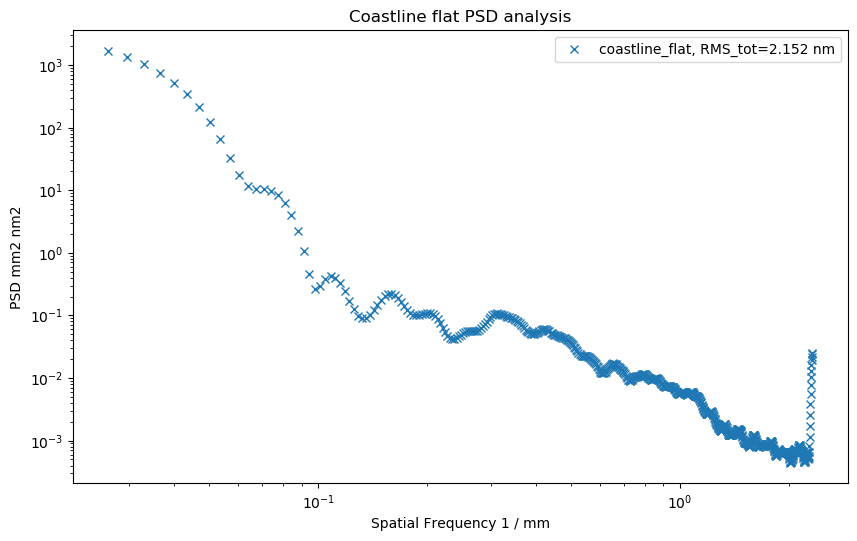

In [3]:
plt.figure(figsize=[10,6],dpi=100)
plt.loglog(clf.k_radial.value, clf.psd_radial_cal.value, 'x', label='{0}, RMS_tot={1:.3f}'.format(clf.surf_name, clf.rms_tot))
plt.xlabel('Spatial Frequency {0}'.format(clf.k_radial.unit))
plt.ylabel('PSD {0}'.format(clf.psd_radial_cal.unit))
plt.title('Coastline flat PSD analysis'.format(opt_parms['ca']))
plt.legend()
#plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))
#plt.axvline(x=0.1, color='b')

The spike at the end of the PSD is because there are blips present at the top and bottom edges of the PSD. This corresponds to the sine-wave type pattern (series of horizontal lines) from the surface data.

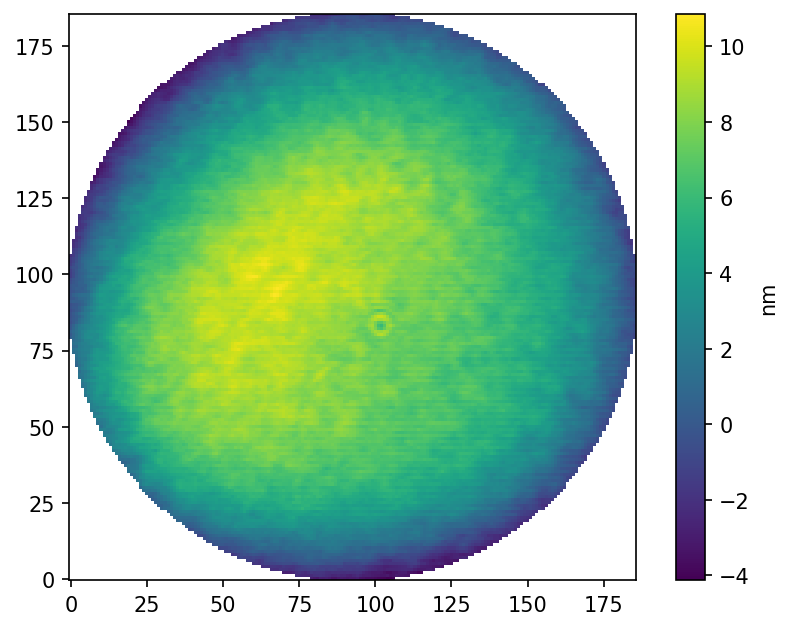

In [4]:
disp_data = clf.data.to(u.nm)
plt.figure(figsize=[7,5], dpi=150)
plt.imshow(dfx.sn_map(disp_data.value, clf.mask), origin='lower')
plt.colorbar().set_label(disp_data.unit)

Text(0.5, 1.0, 'Top blip on PSD')

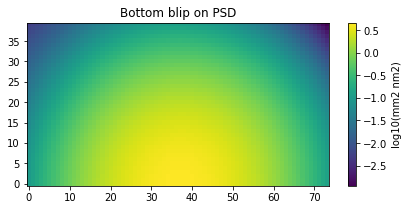

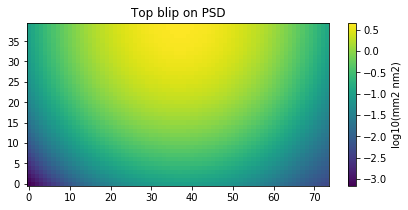

In [5]:
rhalf = 20
chalf = 37

box1 = clf.psd_cal[0:(2*rhalf), (2048-chalf):(2048+chalf)]
plt.figure(figsize=[7,3])
plt.imshow(np.log10(box1.value), origin='lower')
plt.colorbar().set_label('log10({0})'.format(clf.psd_cal.unit))
plt.title('Bottom blip on PSD')

box2 = clf.psd_cal[(4096-2*rhalf):4096, (2048-chalf):(2048+chalf)]
plt.figure(figsize=[7,3])
plt.imshow(np.log10(box2.value), origin='lower')
plt.colorbar().set_label('log10({0})'.format(clf.psd_cal.unit))
plt.title('Top blip on PSD')

Mask out the 2 blips from the PSD, do radial analysis to show it goes away.

In [6]:
# mask these regions
rhalf = 20
chalf = 37
clf.psd_cal[0:(2*rhalf), (2048-chalf):(2048+chalf)] = np.nan
clf.psd_cal[(4096-2*rhalf):4096, (2048-chalf):(2048+chalf)] = np.nan
# with a mask on PSD, need to recalculate the RMS values (will affect high spatial freq)
clf.calc_rms_set(kmid_ll=clf.kmid_ll, khigh_ll=clf.khigh_ll, pwr_opt=clf.psd_cal)
#run radial analysis
clf.calc_psd_radial(ring_width=opt_parms['ring_width'])

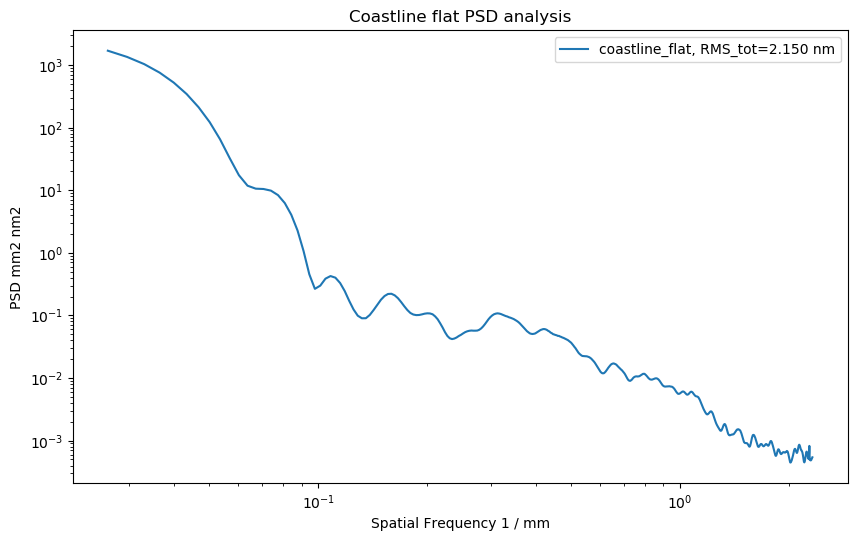

In [10]:
# print plot
plt.figure(figsize=[10,6],dpi=100)
plt.loglog(clf.k_radial.value, clf.psd_radial_cal.value, label='{0}, RMS_tot={1:.3f}'.format(clf.surf_name, clf.rms_tot))
plt.xlabel('Spatial Frequency {0}'.format(clf.k_radial.unit))
plt.ylabel('PSD {0}'.format(clf.psd_radial_cal.unit))
plt.title('Coastline flat PSD analysis'.format(opt_parms['ca']))
plt.legend()
#plt.legend(prop={'size':9},loc='center left', bbox_to_anchor=(1, 0.5))

Save the PSD file for future analysis comparison.

In [11]:
# save this PSD
clf.write_psd_file(filename=filename+'_PSD_masked.fits', psd_data=clf.psd_cal, single_precision=False)